<a href="https://colab.research.google.com/github/Kat-ies/Diploma/blob/main/Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Kat-ies/stylegan2-pytorch.git
%cd /content/stylegan2-pytorch

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 392, done.
remote: Total 392 (delta 0), reused 0 (delta 0), pack-reused 392
Receiving objects: 100% (392/392), 122.51 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (200/200), done.
/content/stylegan2-pytorch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image

img_1 = Image.open('/content/drive/MyDrive/КУ Курсачи/Диплом/000002.png')
img_2 = Image.open('/content/drive/MyDrive/КУ Курсачи/Диплом/000003.png')

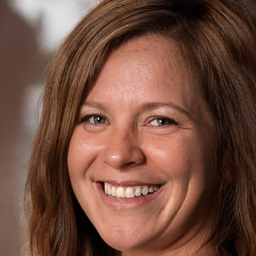

In [ ]:
img_1

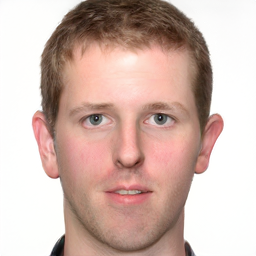

In [ ]:
# we want to get IT!
img_2

In [ ]:
import torch
from torchvision import transforms

def img_to_tensor(img):
    convert_tensor = transforms.ToTensor()
    return convert_tensor(img)

def tensor_to_img(tensor):
    conv = transforms.ToPILImage()
    return conv(tensor)

In [ ]:
# img_1_tensor = img_to_tensor(img_1).requires_grad_(True)
# print(img_1_tensor)

img_2_tensor = img_to_tensor(img_2).to('cuda')
# print(img_2_tensor)

In [ ]:
# need to be installed if it's not
!pip install Ninja

     |████████████████████████████████| 108 kB 4.3 MB/s 


In [ ]:
!python model.py install

In [ ]:
import torch
from torchvision import utils
from model import Generator
from tqdm import tqdm


def generator_params(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    return (img_size, latent_len, n_mlp, chanel_miltiplier, ckpt, device)

def init_generator(img_size=1024, latent_len=512, n_mlp=8, chanel_miltiplier=2, ckpt ='stylegan2-ffhq-config-f.pt', device="cuda"):
    """
    small docs : 
    img_size = 1024 # output image size of the generator
    latent = 512
    n_mlp = 8
    channel_multiplier = 2
    ckpt = 'stylegan2-ffhq-config-f.pt' # channel multiplier of the generator. config-f = 2, else = 1
    """

    g_ema = Generator(img_size, latent_len, n_mlp, channel_multiplier=chanel_miltiplier).to(device)
    checkpoint = torch.load(ckpt)
    g_ema.load_state_dict(checkpoint["g_ema"], strict=False)

    return g_ema


In [ ]:
! rm -f /content/stylegan2-pytorch/sample/*

In [ ]:
from torch import nn


loss_fn = nn.MSELoss()
latent_len = 512
device = 'cuda'
torch.manual_seed(42)
truncation = 0.7

generator = init_generator(ckpt = '/content/drive/MyDrive/ДИ Диплом/models/550000.pt', img_size=256)

sample_z = torch.randn(1, latent_len, dtype=torch.float32, device=torch.device(device), requires_grad=True)
latent_w = torch.tensor(generator.get_latent(sample_z), requires_grad=True)

trunc = generator.mean_latent(4096)

loss_points = []

for i in range(15000):
    step = i % 1000 # [0, ..., 9]
    if step < 10:
        learning_rate = 0.1
    else:
        learning_rate = 0.01

    optimizer = torch.optim.SGD([latent_w], lr=learning_rate, momentum=0.9)
    optimizer.zero_grad()
    gan_image, _ = generator([latent_w], truncation=1, input_is_latent=True)

    loss = loss_fn(gan_image, img_2_tensor)
    loss_points.append(loss.item())
    if i % 1000 == 0:
        print('loss', loss.item())
        utils.save_image(
            gan_image,
            f"sample/{str(i).zfill(6)}.png",
            nrow=1,
            normalize=True,
            range=(-1, 1),
        )
    latent_w.requires_grad_()
    loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_([laent_w], max_norm)
    optimizer.step()


utils.save_image(
    gan_image,
    f"sample/final.png",
    nrow=1,\
    normalize=True,
    range=(-1, 1),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.0+cu111. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 256, 256])) that is different to the input size (torch.Size([1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range

loss 0.7654654383659363
loss 0.2445105016231537
loss 0.1303970366716385
loss 0.09891343116760254
loss 0.08906786143779755
loss 0.08381526172161102
loss 0.08106772601604462
loss 0.07770641148090363
loss 0.0773385539650917
loss 0.07670728862285614
loss 0.07411675900220871
loss 0.07327000796794891
loss 0.0728396624326706
loss 0.07265110313892365
loss 0.07065713405609131


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_loss(y_points, title = 'Loss'):
    x_points = np.arange(0, len(y_points))

    plt.figure(figsize=(20, 10))
    plt.title(title, fontsize=18, fontname='Times New Roman')
    plt.xlabel('Epoch', fontsize=16, fontname='Times New Roman')
    plt.ylabel('Score', fontsize=16, fontname='Times New Roman')
    plt.plot(x_points, y_points, color='#fb607f', linestyle='-')
    #plt.legend([''], loc='center', shadow=True, fontsize=18)
    plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


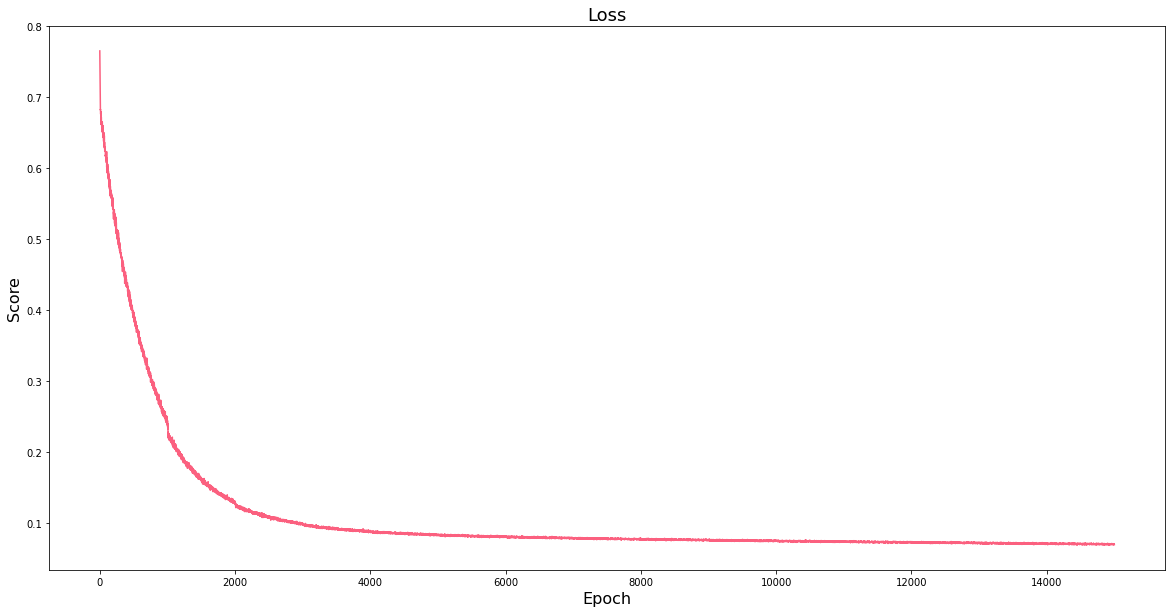

In [ ]:
plot_loss(loss_points)

In [ ]:
import os

def plot_pictures():
    images = []
    images.append(Image.open('/content/drive/MyDrive/КУ Курсачи/Диплом/000003.png'))

    res_dir = '/content/stylegan2-pytorch/sample'
    list_dirs = os.listdir(res_dir)
    list_dirs.sort()
    for cur_file in list_dirs:
        images.append(Image.open(os.path.join(res_dir, cur_file)))

    fig = plt.figure(figsize=(10, 10))
    cols = 4
    rows = 3

    ax = []

    for i in range(cols * rows):
        image = images[i]
        ax.append(fig.add_subplot(rows, cols, i + 1))
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)

    plt.show()


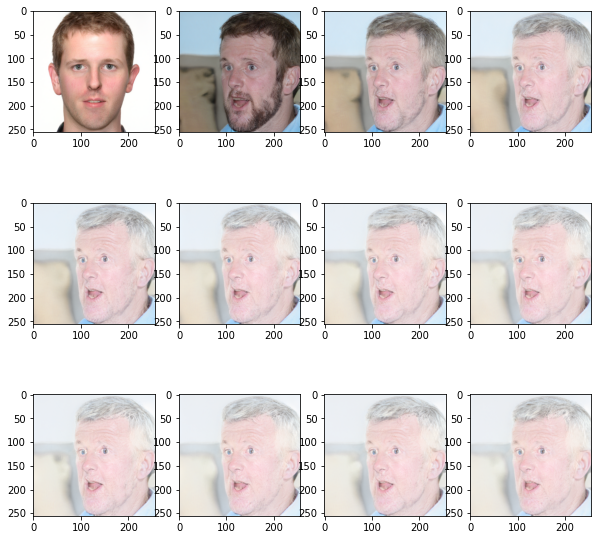

In [ ]:
plot_pictures()

# **Old results**

here can be a mistake, but there results are necessary to compare before and after 

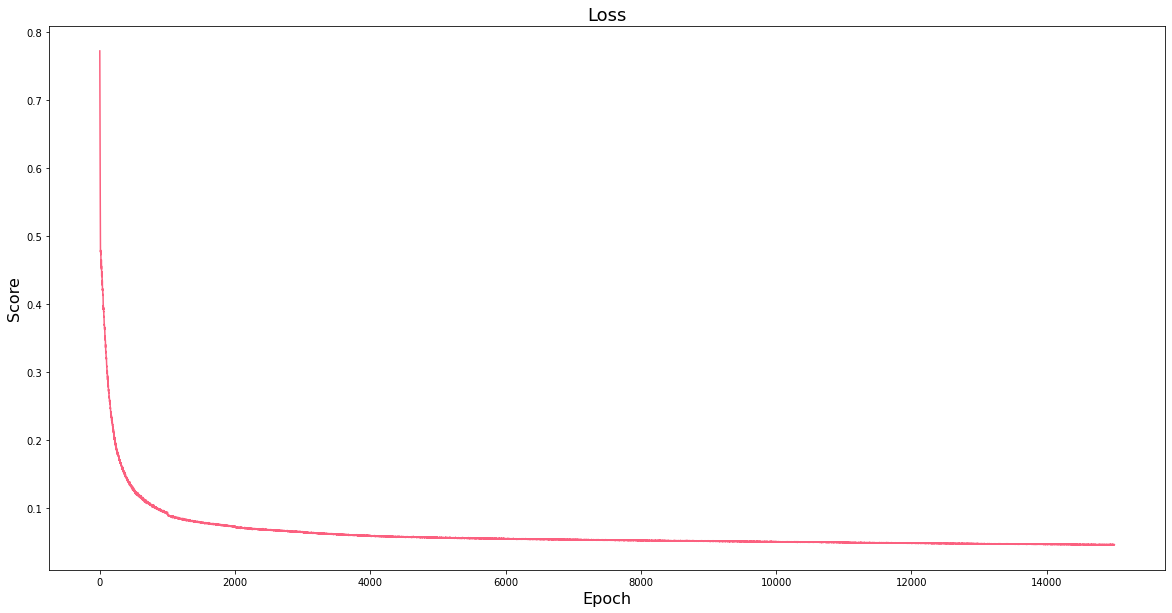

In [ ]:
# gan_image, _ = generator([latent_w], truncation=1, truncation_latent=None)

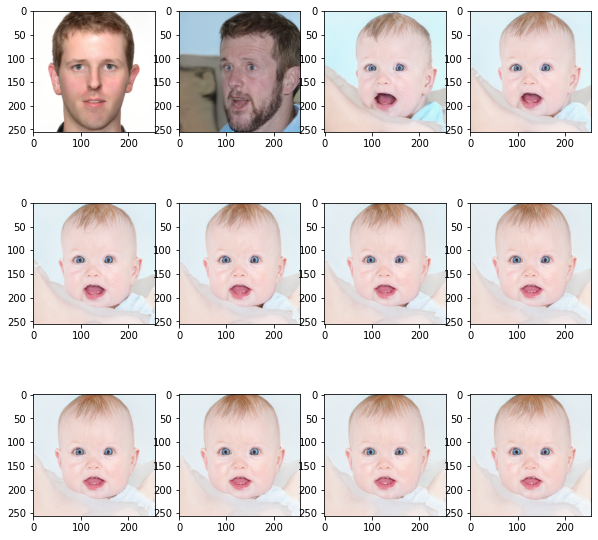

# **Тут могла быть ваша помойка**
(функции, которые "а вдруг пригодится, пусть лежит")

In [ ]:
def generate_pict(generator, latent_vector_w, latent_len=512, device="cuda"):
    pics_number = 1 # number of images to be generated
    sample_num = 1 # number of samples to be generated for each image

    with torch.no_grad():
        generator.eval()
        for i in tqdm(range(pics_number)):

            # sample_z = torch.ones(sample_num, args.latent, device=device) # old version
            # sample_z = torch.tensor([latent_vector_w], dtype=torch.float32, device=torch.device(device), requires_grad=True)

            """
            # maybe will be needed
            truncation = 1 # truncation ratio
            truncation_mean = 4096 # number of vectors to calculate mean for the truncation
            if truncation < 1:
                with torch.no_grad():
                    mean_latent = g_ema.mean_latent(truncation_mean)
            else:
                mean_latent = None
            """

            image, _ = generator([latent_vector_w], truncation=1, truncation_latent=None)

            utils.save_image(
                image,
                f"sample/{str(i).zfill(6)}.png",
                nrow=1,
                normalize=True,
                range=(-1, 1),
            )
            
            print(image)


In [ ]:
from torch import nn


loss_fn = nn.MSELoss()

for i in range(60000):
    optimizer = torch.optim.SGD([img_1_tensor], lr=0.1, momentum=0.9, weight_decay=0)
    optimizer.zero_grad()

    loss = loss_fn(img_1_tensor, img_2_tensor)
    if i % 100000 == 0:
        print('loss', loss.item())
    loss.backward()
    optimizer.step()


loss 0.1290835291147232
